<a href="https://colab.research.google.com/github/mikekvashchuk888/Mykhailo-Kvashchuk-s-Projects/blob/main/01_medical_imaging_detection/medical_imaging_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

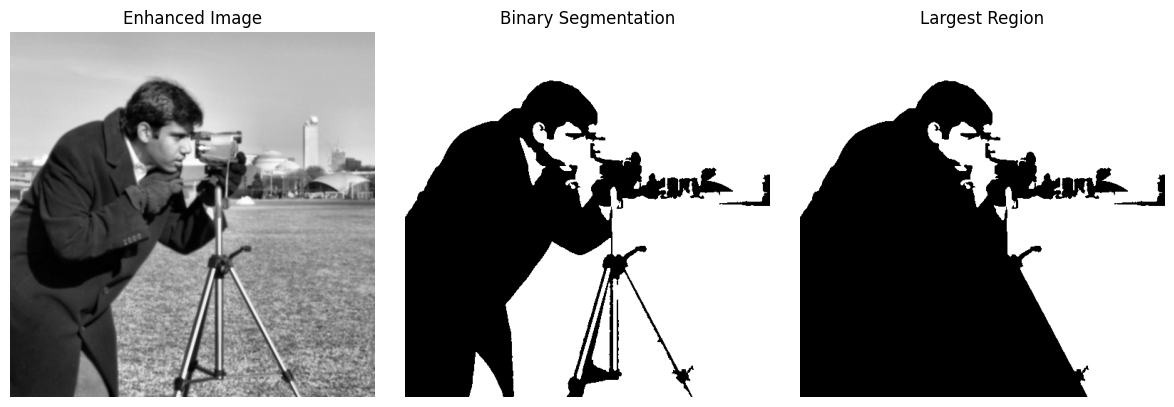

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, exposure, morphology, measure


img = data.camera()


img_smooth = filters.gaussian(img, sigma=1.0)
img_eq = exposure.equalize_adapthist(img_smooth)


thresh = filters.threshold_otsu(img_eq)
mask = img_eq > thresh


mask_clean = morphology.remove_small_objects(mask, min_size=500)
mask_clean = morphology.remove_small_holes(mask_clean, area_threshold=500)

s
labels = measure.label(mask_clean)
regions = measure.regionprops(labels)


largest = max(regions, key=lambda r: r.area) if regions else None
largest_mask = (labels == largest.label) if largest else np.zeros_like(mask_clean, dtype=bool)


plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Enhanced Image")
plt.imshow(img_eq, cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Binary Segmentation")
plt.imshow(mask_clean, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Largest Region")
plt.imshow(largest_mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
if largest:
    print("Largest region measurements:")
    print("Area (pixels):", largest.area)
    print("Perimeter (pixels):", largest.perimeter)
    print("Centroid (row, col):", largest.centroid)
    print("Eccentricity:", largest.eccentricity)
else:
    print("No regions detected. Try adjusting min_size or area_threshold.")


Largest region measurements:
Area (pixels): 138773.0
Perimeter (pixels): 4082.9810229537425
Centroid (row, col): (np.float64(188.1023830283989), np.float64(325.3768024039258))
Eccentricity: 0.8028115097777738


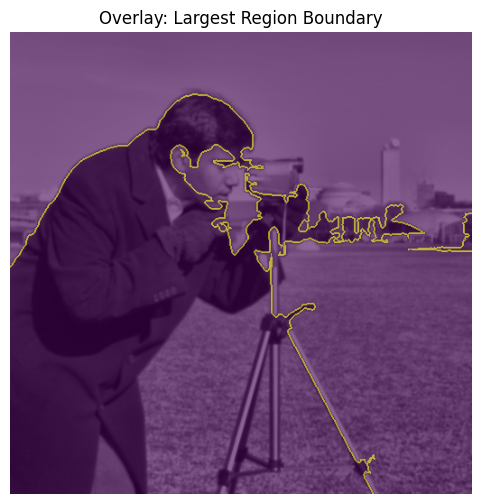

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology


boundary = morphology.binary_dilation(largest_mask, morphology.disk(2)) ^ largest_mask

plt.figure(figsize=(6,6))
plt.title("Overlay: Largest Region Boundary")
plt.imshow(img_eq, cmap="gray")
plt.imshow(boundary, alpha=0.6)
plt.axis("off")
plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, exposure, morphology, measure

def process_image(img, sigma=1.0, min_size=500, hole_area=500, show=True):
    """
    Image processing pipeline:
    1) smooth
    2) contrast enhance
    3) threshold (Otsu)
    4) clean mask
    5) largest connected region
    6) measurements + figures
    """

    img_smooth = filters.gaussian(img, sigma=sigma)
    img_eq = exposure.equalize_adapthist(img_smooth)


    thresh = filters.threshold_otsu(img_eq)
    mask = img_eq > thresh


    mask_clean = morphology.remove_small_objects(mask, min_size=min_size)
    mask_clean = morphology.remove_small_holes(mask_clean, area_threshold=hole_area)


    labels = measure.label(mask_clean)
    regions = measure.regionprops(labels)
    largest = max(regions, key=lambda r: r.area) if regions else None
    largest_mask = (labels == largest.label) if largest else np.zeros_like(mask_clean, dtype=bool)


    boundary = morphology.binary_dilation(largest_mask, morphology.disk(2)) ^ largest_mask


    metrics = {}
    if largest:
        metrics = {
            "area_pixels": float(largest.area),
            "perimeter_pixels": float(largest.perimeter),
            "centroid_row": float(largest.centroid[0]),
            "centroid_col": float(largest.centroid[1]),
            "eccentricity": float(largest.eccentricity),
            "otsu_threshold": float(thresh),
        }


    if show:
        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.title("Enhanced")
        plt.imshow(img_eq, cmap="gray")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.title("Segmentation (Clean)")
        plt.imshow(mask_clean, cmap="gray")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.title("Overlay Boundary")
        plt.imshow(img_eq, cmap="gray")
        plt.imshow(boundary, alpha=0.6)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        print("Metrics:", metrics)

    return img_eq, mask_clean, largest_mask, boundary, metrics


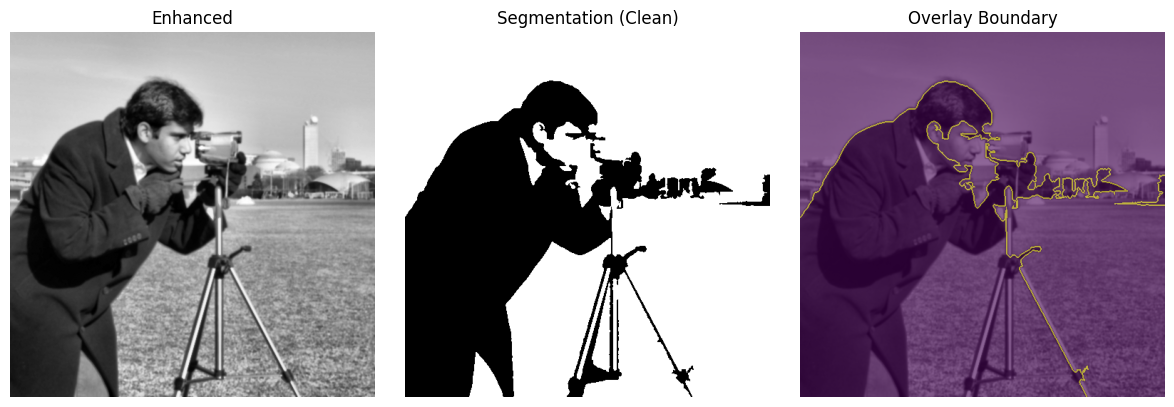

Metrics: {'area_pixels': 138773.0, 'perimeter_pixels': 4082.9810229537425, 'centroid_row': 188.1023830283989, 'centroid_col': 325.3768024039258, 'eccentricity': 0.8028115097777738, 'otsu_threshold': 0.435546875}


In [16]:
img = data.camera()
img_eq, mask_clean, largest_mask, boundary, metrics = process_image(img)


In [17]:
import os

out_dir = "figures_validation"
os.makedirs(out_dir, exist_ok=True)


plt.figure(figsize=(6,6))
plt.title("Enhanced")
plt.imshow(img_eq, cmap="gray")
plt.axis("off")
plt.savefig(f"{out_dir}/validation_enhanced.png", bbox_inches="tight", dpi=200)
plt.close()

plt.figure(figsize=(6,6))
plt.title("Segmentation")
plt.imshow(mask_clean, cmap="gray")
plt.axis("off")
plt.savefig(f"{out_dir}/validation_segmentation.png", bbox_inches="tight", dpi=200)
plt.close()

plt.figure(figsize=(6,6))
plt.title("Largest Region")
plt.imshow(largest_mask, cmap="gray")
plt.axis("off")
plt.savefig(f"{out_dir}/validation_largest_region.png", bbox_inches="tight", dpi=200)
plt.close()

plt.figure(figsize=(6,6))
plt.title("Overlay")
plt.imshow(img_eq, cmap="gray")
plt.imshow(boundary, alpha=0.6)
plt.axis("off")
plt.savefig(f"{out_dir}/validation_overlay.png", bbox_inches="tight", dpi=200)
plt.close()

print("Saved files in:", out_dir)
print(os.listdir(out_dir))


Saved files in: figures_validation
['validation_largest_region.png', 'validation_overlay.png', 'validation_enhanced.png', 'validation_segmentation.png']


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, img_as_float
from ipywidgets import interact, Dropdown

def get_sample_image(choice):
    if choice == "camera (validation)":
        img = data.camera()
    elif choice == "coins":
        img = data.coins()
    elif choice == "cells":
        img = data.cells3d()[:, 1, :, :]
        img = img[20]
    elif choice == "horse (binary)":
        img = data.horse().astype(float)
    else:
        img = data.camera()


    if img.ndim == 3:
        img = color.rgb2gray(img)
    img = img_as_float(img)
    return img

def run_sample(choice="camera (validation)", sigma=1.0, min_size=500, hole_area=500):
    img = get_sample_image(choice)
    _ = process_image(img, sigma=sigma, min_size=min_size, hole_area=hole_area, show=True)

interact(
    run_sample,
    choice=Dropdown(options=["camera (validation)", "coins", "cells", "horse (binary)"], value="camera (validation)"),
    sigma=(0.0, 3.0, 0.2),
    min_size=(50, 3000, 50),
    hole_area=(50, 3000, 50)
);


interactive(children=(Dropdown(description='choice', options=('camera (validation)', 'coins', 'cells', 'horse …

Saving Gallary 1(xray).png to Gallary 1(xray).png


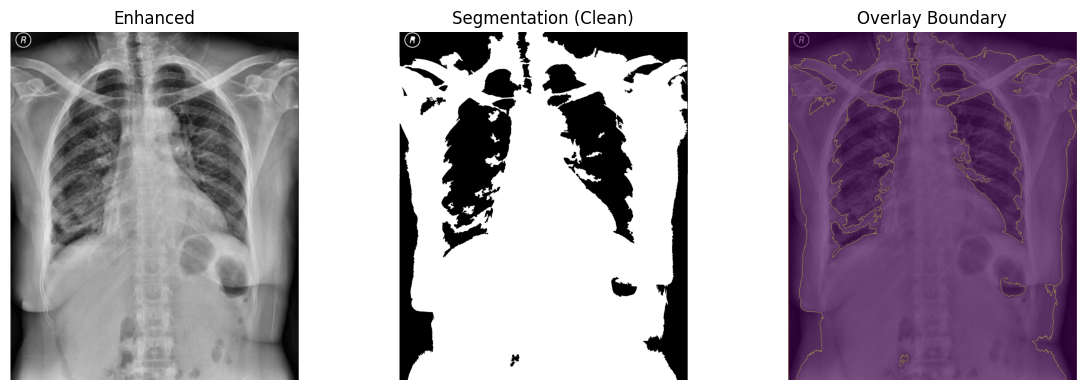

Metrics: {'area_pixels': 2428570.0, 'perimeter_pixels': 32212.299694993766, 'centroid_row': 1133.1126333603725, 'centroid_col': 855.1240293670761, 'eccentricity': 0.6013575433573107, 'otsu_threshold': 0.447265625}


In [20]:
from google.colab import files
from skimage import io

def upload_and_run(sigma=1.0, min_size=500, hole_area=500):
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = io.imread(fn, as_gray=True)
        _ = process_image(img, sigma=sigma, min_size=min_size, hole_area=hole_area, show=True)

upload_and_run()


In [28]:
import os
import matplotlib.pyplot as plt
from skimage import io


fn = "xray_test1.jpg"

img = io.imread(fn, as_gray=True)
img_eq, mask_clean, largest_mask, boundary, metrics = process_image(img, show=False)

out_dir = "figures_imaging_addon"
os.makedirs(out_dir, exist_ok=True)


plt.figure(figsize=(6,6))
plt.title("X-ray - Enhanced")
plt.imshow(img_eq, cmap="gray")
plt.axis("off")
plt.savefig(f"{out_dir}/xray_enhanced.png", dpi=200, bbox_inches="tight")
plt.close()


plt.figure(figsize=(6,6))
plt.title("X-ray - Segmentation")
plt.imshow(mask_clean, cmap="gray")
plt.axis("off")
plt.savefig(f"{out_dir}/xray_segmentation.png", dpi=200, bbox_inches="tight")
plt.close()


plt.figure(figsize=(6,6))
plt.title("X-ray - Overlay")
plt.imshow(img_eq, cmap="gray")
plt.imshow(boundary, alpha=0.6)
plt.axis("off")
plt.savefig(f"{out_dir}/xray_overlay.png", dpi=200, bbox_inches="tight")
plt.close()


with open(f"{out_dir}/xray_metrics.txt", "w") as f:
    f.write(str(metrics))

print("Saved in:", out_dir)
print(os.listdir(out_dir))
print("Metrics:", metrics)


Saved in: figures_imaging_addon
['xray_segmentation.png', 'xray_metrics.txt', 'xray_enhanced.png', 'xray_overlay.png']
Metrics: {'area_pixels': 2428570.0, 'perimeter_pixels': 32212.299694993766, 'centroid_row': 1133.1126333603725, 'centroid_col': 855.1240293670761, 'eccentricity': 0.6013575433573107, 'otsu_threshold': 0.447265625}


In [35]:
import os
os.makedirs("sample_images", exist_ok=True)
print("Folder exists:", os.path.exists("sample_images"))


Folder exists: True


In [37]:
import shutil, os

src = "xray_test1.jpg"
dst = os.path.join("sample_images", "xray_chest.png")

shutil.copy(src, dst)
print("Files in sample_images:", os.listdir("sample_images"))


Files in sample_images: ['xray_chest.png']
